## AWS y Intel Hackathon: Model Training

### Install Python SDKs

In [ ]:
import sys

In [ ]:
!{sys.executable} -m pip install sagemaker-experiments==0.1.24

### Install PyTroch

In [ ]:
!{sys.executable} -m pip install torch==1.1.0
!{sys.executable} -m pip install torchvision==0.3.0
!{sys.executable} -m pip install pillow==6.2.2
!{sys.executable} -m pip install --upgrade sagemaker
!{sys.executable} -m pip install torchsummary

### Setup

In [ ]:
import time

import boto3
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats, display
from matplotlib import pyplot as plt
from torchvision import datasets, transforms, models

import torch

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session

from tqdm.notebook import tqdm

from torchsummary import summary
import glob
from PIL import Image

import random

set_matplotlib_formats("retina")

### Download the data

In [ ]:
!mkdir data

### Original dataset
Run the two cells below to use the original dataset. It should provide good results in training and test although the training process will take several minutes.

In [ ]:
!wget https://www.dropbox.com/s/zhljom0hth586p9/dataset_original.zip

In [ ]:
!mv dataset_original.zip data/dataset.zip
!unzip -quo data/dataset.zip -d data/

dataset_path = "./data/dataset.zip"

### Reduced Dataset
Run the two cells below to use the reduced dataset. It should provide worse results than the original but it will reduce the training process time.

In [ ]:
!wget https://www.dropbox.com/s/evm0ts2obk7n3cb/dataset_reduced.zip

In [ ]:
!mv dataset_reduced.zip data/dataset.zip
!unzip -quo data/dataset.zip -d data/

dataset_path = "./data/dataset.zip"


### Dataset_for_tests
Run the two cells below to use a very reduced dataset. It can be used for very fast tests although it will yield to very poor results in the predictions and training accuracy. 

In [ ]:
!wget https://www.dropbox.com/s/zivlm0skt19k3wh/dataset_for_tests.zip

In [ ]:
!mv dataset_for_tests.zip data/dataset.zip
!unzip -quo data/dataset.zip -d data/

dataset_path = "./data/dataset.zip"

### Upload dataset to S3 as zip file

In [ ]:
sm_sess = sagemaker.Session()
sess = sm_sess.boto_session
sm = sm_sess.sagemaker_client
role = get_execution_role()

In [ ]:
account_id = sess.client("sts").get_caller_identity()["Account"]
bucket = "sagemaker-hackathon-demo-{}-{}".format(sess.region_name, account_id)
prefix = "hackathon"

try:
    if sess.region_name == "us-east-1":
        sess.client("s3").create_bucket(Bucket=bucket)
    else:
        sess.client("s3").create_bucket(
            Bucket=bucket, CreateBucketConfiguration={"LocationConstraint": sess.region_name}
        )
except Exception as e:
    print(e)

In [ ]:
bucket

In [ ]:
s3_resource = boto3.resource("s3", region_name = sess.region_name)

inputs = None

try:

    
    inputs = sagemaker.Session().upload_data(path=dataset_path, bucket=bucket, key_prefix=prefix)
    print("input spec: {}".format(inputs))
except Exception as exp:
    print("exp: ", exp)


### Training

In [168]:
!pygmentize model.py

import argparse
import json
import logging
import os
import sys

#import sagemaker_containers
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms

import boto3
import zipfile
from torch.utils.data import DataLoader

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

img_transform= {
    'dataset':
    transforms.Compose([
        transforms.Resize((28, 28)), 
        transforms.ToTensor(),
    ]),
    'training':
    transforms.Compose([
         transforms.RandomResizedCrop(size=224),
         transforms.RandomHorizontalFlip(),
    ]),
    'validation': 
    transforms.Compose([
        transforms.Resize(size=224),
    ]),
    'testing': 
    transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]),

In [169]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="model.py",
    role=role,
    framework_version="1.4.0",
    py_version="py3",
    instance_count=2,
    instance_type="ml.m4.xlarge",
    hyperparameters={"epochs": 6, "backend": "gloo"},
)

In [170]:
estimator.fit({"training": inputs})

2022-04-20 14:25:51 Starting - Starting the training job...
2022-04-20 14:26:17 Starting - Preparing the instances for trainingProfilerReport-1650464751: InProgress
.........
2022-04-20 14:27:45 Downloading - Downloading input data...
2022-04-20 14:28:19 Training - Downloading the training image......
2022-04-20 14:29:20 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-20 14:29:24,821 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-20 14:29:24,825 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-04-20 14:29:24,842 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-20 14:29:24,851 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-20 14:29:25,377 sagemaker-containers INFO     Module defaul

In [171]:
estimator.model_data

's3://sagemaker-eu-west-1-017233837209/pytorch-training-2022-04-20-14-25-51-446/output/model.tar.gz'

### Deployment

In [172]:
estimator.model_data

's3://sagemaker-eu-west-1-017233837209/pytorch-training-2022-04-20-14-25-51-446/output/model.tar.gz'

First we create a folder to save model trained model, and download the model.tar.gz file to local directory.

In [175]:
%%sh -s $estimator.model_data
mkdir model
aws s3 cp $1 model/ 
tar xvzf model/model.tar.gz --directory ./model

download: s3://sagemaker-eu-west-1-017233837209/pytorch-training-2022-04-20-14-25-51-446/output/model.tar.gz to model/model.tar.gz
model.pth
model.pth


Convert your model into the TorchScript format using torch.jit.trace or torch.jit.script.

In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model_loaded = torch.load("model/model.pth")
model = Net().to("cpu")
model = torch.nn.DataParallel(model)
model.load_state_dict(model_loaded)

<All keys matched successfully>

In [179]:
import subprocess

trace_input = torch.rand(1, 3, 28, 28)
traced_model = torch.jit.trace(model.eval(), trace_input)

torch.jit.save(traced_model, "model.pth")
subprocess.call(["tar", "-czvf", "traced_hackathon_model.tar.gz", "model.pth"])

0

In [180]:
!pygmentize deploy_ei.py

# Copyright 2019-2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.
from __future__ import absolute_import

import logging
import os
import sys

import torch

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

# To use new EIA inference API, customer should use attach_eia(model, eia_ordinal_number)
VERSIONS_USE_NEW_API = ["1.5.1"]


def predict_fn(input_data, model):
    logger.info(
        "Performing EIA inference with T

In [181]:
from sagemaker.pytorch import PyTorchModel
from datetime import datetime

instance_type = "ml.m4.xlarge"

# TorchScript model
tar_filename = "traced_hackathon_model.tar.gz"

# You can also upload model artifacts to S3
# print('Upload tarball to S3')
# model_data = sagemaker_session.upload_data(path=tar_filename, bucket=bucket, key_prefix=prefix)
model_data = tar_filename

endpoint_name = ("hackathon-ei-traced").replace(".", "").replace("_", "")

In [182]:
pytorch = PyTorchModel(
    model_data=model_data,
    role=role,
    entry_point="deploy_ei.py",
    framework_version="1.3.1",
    py_version="py3",
    sagemaker_session=sagemaker_session,
)

In [185]:
# Attach EI remotely

# Function will exit before endpoint is finished creating
predictor = pytorch.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=endpoint_name,
    wait=True,
)


------!

img_resized (28, 28, 3)
x shape torch.Size([1, 3, 28, 28])


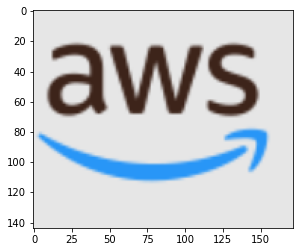

In [201]:
#Import Pytorch
import torch
import torchvision

import cv2 
import matplotlib.pyplot as plt


convert = torchvision.transforms.ToTensor()

file = "./aws.png"
# test_image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
test_image = cv2.imread(file)
plt.imshow(test_image, cmap='gray')

img_resized = cv2.resize(test_image, (28, 28), interpolation=cv2.INTER_LINEAR)
img_resized = cv2.bitwise_not(img_resized)
print("img_resized", img_resized.shape)

## Get our input image as a tensor. We add a dimension with "unsqueeze", because
## PyTorch is used to working with batches.
x = convert(img_resized).unsqueeze(0)

print("x shape", x.shape)




In [204]:
import numpy as np

# im_ = np.random.rand(1, 1, 28, 28)

# image = np.array(im_, dtype=np.float32)
response = predictor.predict(x)
print("response", response)
prediction = response.argmax(axis=1)[0]
print(prediction)

response [[-2.27607346 -2.33181691 -2.42464399 -2.27142167 -2.198632   -2.37246609
  -2.32089543 -2.27894354 -2.29596758 -2.27232647]]
4


In [205]:
predictor.delete_endpoint()